## Generate temperature and salinity initial fields from CASE-STSE output

1. Calculate monthly T and S means (or seasonal?) from CASE-STSE daily output
2. Interpolate T and S mean fields into model SVB model grid
3. Save binary file

In [17]:
import cmocean as cmo
import datetime as dt
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
import MITgcmutils as mit
import numpy as np
import scipy as sc
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
import scipy.io as sio
from matplotlib.gridspec import GridSpec
import seawater as sw
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [50]:
def read_bin(file, shape, k=0, dtype='>f4'):
    '''Read the binary file. 
    If k='all', it reads the whole file, 
    if k=tt, where tt is an integer, then it reads the time output tt,
    if k=(t0,tf), tuple, then it reads from t0 to tf.
    Default is to read first time output, k=0.
    shape:: tuple with the final shape of the 
            data in order (nt,ny,nx,nz) for 
            3D + time fields or (nt,ny,nx) for 
            2D + time fields.
    dtype:: string with any accepted python format. 
            Most common are '>f8' equivalent to real*8, 
            ieee-b and '>f4' equivalent to real*4, ieee-b.
    RETURNS
    Numpy array of data of shape "shape".
    '''
#    with open(file, 'r') as f:
#        cc = np.fromfile(f,dtype=dtype)
#   return(np.reshape(cc, shape, order='C'))
    shape_arr = np.array(shape)
    nnn = shape_arr.prod()
    WORDLENGTH = 4 # default word length
    with open(file, "rb") as f:
        if k=='all': # Load the whole thing
            cc=np.fromfile(f,dtype=dtype)
        elif isinstance(k, int) == True:
            offs=nnn*k*WORDLENGTH
            #f.seek(nnn*k*WORDLENGTH)
            cc=np.fromfile(f,offset=offs,count=nnn,dtype=dtype)  
        else:
            slice_nnn = shape_arr[1:].prod()
            offs=slice_nnn*k[0]*WORDLENGTH
            #f.seek(nnn*k*WORDLENGTH)
            cc=np.fromfile(f,offset=offs,count=nnn,dtype=dtype)
            
    return(np.reshape(cc, shape, order='C'))


def load_bat(file):
    '''Load X, Y and Z arrays from mat file'''
    bathy = sio.loadmat(bathy_file)
    return(bathy['XC'][:], bathy['YC'][:], bathy['RC'][:])

def load_depth(file):
    '''Load depth array from mat file'''
    bathy = sio.loadmat(bathy_file)
    return(bathy['Depth'][:])

def matlab2datetime(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days = 366)
    return day + dayfrac

def plot_fld_anim(ax,XC,YC,eta_slice,title,vmin=-0.15, vmax=0.15,cmap=cmo.cm.balance,clab=r'Free surface (m)'):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC,YC,eta_slice, cmap=cmap, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(pc, ax=ax, format='%1.2f', label=clab)
    #cmap = cmap
    #norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    #cbar_ax = fig.add_axes([0.89, 0.125, 0.022, 0.755])
    #cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    #                  cax=cbar_ax, orientation='vertical', 
    #                  format='%1.2f', label=clab)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.set_aspect(1)
    width = 7
    height = 8
    rect = patches.Rectangle((239,27),width,height,linewidth=2,edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    #ax.set_xlim(XC[0],XC[-1],)
    #ax.set_ylim(YC[0],YC[-1],)
    
    return(ax)

### 1. Monthly T and S from CASE-STSE

I'll use February and August 2008 (Same months and year discussed in Verdy et al. 2014)

In [3]:
# Data storage location
bathy_file = '/Volumes/MOBY/CASE-CCS/full_domain/grid.mat'
fmt_file = '/Volumes/MOBY/CASE-CCS/full_domain/FMT.mat'

fpath = '/Volumes/MOBY/CASE-CCS/full_domain/'
dpath = '/Volumes/MOBY/CASE-CCS/full_domain/'

In [38]:
# Read coordinates
XC, YC, ZC = load_bat(bathy_file)
depth = load_depth(bathy_file)
nxc = len(XC[:])
nyc = len(YC[0,:]) 
nzc = len(ZC[:])
nt = 4656

In [5]:
# Read date strings
date_strs = read_bin(dpath+'TIME_CCS_2007_2019.bin', (nt), k=0)

feb_tt = (365+31,365+31+29)    # Feb 2008 tuple
feb_nt = feb_tt[-1]-feb_tt[0] # number of days in slice

aug_tt = (365+214,365+214+31) # Aug 2008 tuple
aug_nt = aug_tt[-1]-aug_tt[0]   # number of days in slice

In [6]:
# Read Feb T
T = read_bin(dpath+'T_MIT_CCS_2007_2019_fulldomain.bin', (feb_nt,nzc,nyc,nxc), k=feb_tt)
# Mean Feb T
T_feb = np.nanmean(T, axis=0)

# Read Feb S
S = read_bin(dpath+'S_MIT_CCS_2007_2019_fulldomain.bin', (feb_nt,nzc,nyc,nxc), k=feb_tt)
# Mean Feb S
S_feb = np.nanmean(S, axis=0)

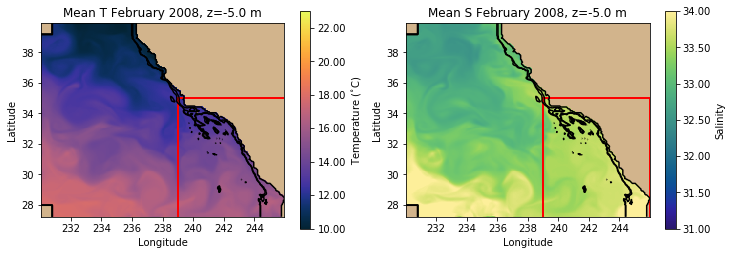

In [7]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4)) 
zz = 0
ax0 = plot_fld_anim(ax0,XC[:,0],YC[0,:],T_feb[zz,:,:],'Mean T February 2008, z=%1.1f m' %(ZC[zz]),
                    vmin=10,vmax=23,cmap=cmo.cm.thermal,clab='Temperature ($^{\circ}$C)')
cn0 = ax0.contour(XC,YC,depth, levels=[0,250, 500], colors='k')

ax1 = plot_fld_anim(ax1,XC[:,0],YC[0,:],S_feb[zz,:,:],'Mean S February 2008, z=%1.1f m' %(ZC[zz]),
                    vmin=31,vmax=34,cmap=cmo.cm.haline,clab='Salinity')
cn1 = ax1.contour(XC,YC,depth, levels=[0,250, 500], colors='k')
plt.show()

In [8]:
# Read Aug T
T = read_bin(dpath+'T_MIT_CCS_2007_2019_fulldomain.bin', (aug_nt,nzc,nyc,nxc), k=aug_tt)
# Mean Aug T
T_aug = np.nanmean(T, axis=0)

# Read Aug S
S = read_bin(dpath+'S_MIT_CCS_2007_2019_fulldomain.bin', (aug_nt,nzc,nyc,nxc), k=aug_tt)
# Mean Aug S
S_aug = np.nanmean(S, axis=0)

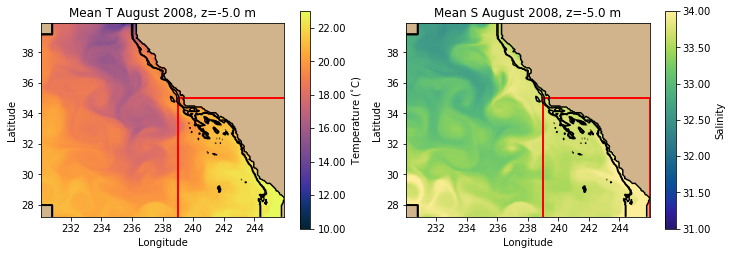

In [9]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4)) 

ax0 = plot_fld_anim(ax0,XC[:,0],YC[0,:],T_aug[0,:,:],'Mean T August 2008, z=%1.1f m' %(ZC[zz]),
                    vmin=10,vmax=23,cmap=cmo.cm.thermal,clab='Temperature ($^{\circ}$C)')
cn0 = ax0.contour(XC,YC,depth, levels=[0,250, 500], colors='k')

ax1 = plot_fld_anim(ax1,XC[:,0],YC[0,:],S_aug[0,:,:],'Mean S August 2008, z=%1.1f m' %(ZC[zz]),
                    vmin=31,vmax=34,cmap=cmo.cm.haline,clab='Salinity')
cn1 = ax1.contour(XC,YC,depth, levels=[0,250, 500], colors='k')
plt.show()


Now I have to fill NaNs (land mask) with reasonable values so that I can interpolate into the SVB model's grid without having problems due to the bathymerty mismatch between models.

For that I interpolate the non-NaN values of the mean monthly fields into land using griddata (`method='nearest'` worked best) 

In [10]:
def remove_nans_interp(fld, XC, YC, nz):
    '''Interpolate CASE-STSE output into land.
    Input:
    fld: 3D field of T or S
    XC: 2D lon values mesh
    YC: 2D lat values mesh
    nz: number of depth levels
    Output:
    fld_noNaN: 3D field same size as fld with interpolates values on land.'''
    
    fld_noNaN = np.zeros_like(fld)
    for kk in range(nz):
        #mask invalid values
        array = np.ma.masked_invalid(fld[kk,:,:])
        #get only the valid values
        x1 = np.transpose(XC)[~array.mask]
        y1 = np.transpose(YC)[~array.mask]
        newarr = array[~array.mask]

        interp_fld = griddata((x1, y1), newarr.ravel(),(XC, YC), method='nearest')
        fld_noNaN[kk,:,:] = np.transpose(interp_fld)
    return fld_noNaN

In [11]:
# Interpolate T and S mean fields for February and August
T_feb_noNaN = remove_nans_interp(T_feb, XC, YC, nzc)
S_feb_noNaN = remove_nans_interp(S_feb, XC, YC, nzc)
T_aug_noNaN = remove_nans_interp(T_aug, XC, YC, nzc)
S_aug_noNaN = remove_nans_interp(S_aug, XC, YC, nzc)

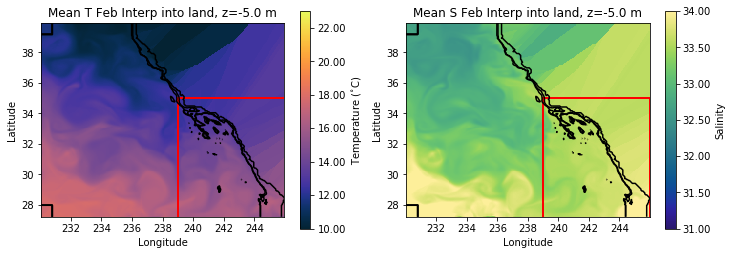

In [12]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4)) 
zz = 0
ax0 = plot_fld_anim(ax0,XC[:,0],YC[0,:],T_feb_noNaN[zz,:,:],'Mean T Feb Interp into land, z=%1.1f m' %(ZC[zz]),
                    vmin=10,vmax=23,cmap=cmo.cm.thermal,clab='Temperature ($^{\circ}$C)')
cn0 = ax0.contour(XC,YC,depth, levels=[0,250, 500], colors='k')

ax1 = plot_fld_anim(ax1,XC[:,0],YC[0,:],S_feb_noNaN[zz,:,:],'Mean S Feb Interp into land, z=%1.1f m' %(ZC[zz]),
                    vmin=31,vmax=34,cmap=cmo.cm.haline,clab='Salinity')
cn1 = ax1.contour(XC,YC,depth, levels=[0,250, 500], colors='k')
plt.show()

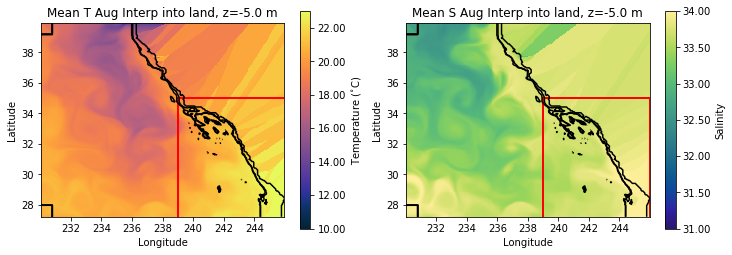

In [13]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4)) 
zz = 0
ax0 = plot_fld_anim(ax0,XC[:,0],YC[0,:],T_aug_noNaN[zz,:,:],'Mean T Aug Interp into land, z=%1.1f m' %(ZC[zz]),
                    vmin=10,vmax=23,cmap=cmo.cm.thermal,clab='Temperature ($^{\circ}$C)')
cn0 = ax0.contour(XC,YC,depth, levels=[0,250, 500], colors='k')

ax1 = plot_fld_anim(ax1,XC[:,0],YC[0,:],S_aug_noNaN[zz,:,:],'Mean S Aug Interp into land, z=%1.1f m' %(ZC[zz]),
                    vmin=31,vmax=34,cmap=cmo.cm.haline,clab='Salinity')
cn1 = ax1.contour(XC,YC,depth, levels=[0,250, 500], colors='k')
plt.show()

Note that stuff on land looks ugly but the rest is fine.

### 2. Interpolate monthly mean T and S into SVB model grid

Interpolate into cell centers (ZC, YC, XC)

In [15]:
outdir = '/Volumes/balaenopter/06_512x612x100_ORL_SVB/01_SVB_febTS/'

In [59]:
# Load grid variables
ds = open_mdsdataset(outdir, prefix=['eta'], iters=[10])
depth_SVB = ds['Depth'][:]
Yy = ds['YC'][:]
Xx= ds['XC'][:]
ZC_svb = ds['Z'][:]

XC_svb, YC_svb = np.meshgrid(Xx,Yy) 

hFacC = ds['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)

In [60]:
def interp_into_SVBgrid(fld, XX,YY,ZZ):
    '''Interpolate mean fileds form CASE-STSE into SVB model grid
    fld: 3d array of CASE-STSE T or S without NaNs
    XX: 2d x mesh
    YY: 2d y mesh
    ZZ: 1d z coordinte
    Output:
    fld_interp: array of interpolated T or S'''
    fn_lin = RegularGridInterpolator((np.squeeze(-ZC),
                                      np.squeeze(YC[0,:]),
                                      np.squeeze(XC[:,0])), fld, 
                                     bounds_error=False, method="linear", fill_value=None)
    xyz_grid = np.meshgrid(np.squeeze(-ZZ[:]),
                           np.squeeze(YY[:,0]), 
                           np.squeeze(XX[0,:]), 
                           indexing='ij')
    xyz_list = np.reshape(xyz_grid, (3, -1), order='C').T
    fld_interp = fn_lin(xyz_list)
    return(fld_interp)

In [61]:
T_feb_interp = interp_into_SVBgrid(T_feb_noNaN, XC_svb, YC_svb,ZC_svb) 
S_feb_interp = interp_into_SVBgrid(S_feb_noNaN, XC_svb, YC_svb,ZC_svb) 
T_aug_interp = interp_into_SVBgrid(T_aug_noNaN, XC_svb, YC_svb,ZC_svb)
S_aug_interp = interp_into_SVBgrid(S_aug_noNaN, XC_svb, YC_svb,ZC_svb)

In [62]:
nxx = len(XC_svb[0,:])
nyy = len(YC_svb[:,0])
nzz = len(ZC_svb)

T_feb_reshape = np.reshape(T_feb_interp, (nzz,nyy,nxx))
print(np.shape(T_feb_reshape))
S_feb_reshape = np.reshape(S_feb_interp, (nzz,nyy,nxx))
T_aug_reshape = np.reshape(T_aug_interp, (nzz,nyy,nxx))
S_aug_reshape = np.reshape(S_aug_interp, (nzz,nyy,nxx))

(100, 612, 512)


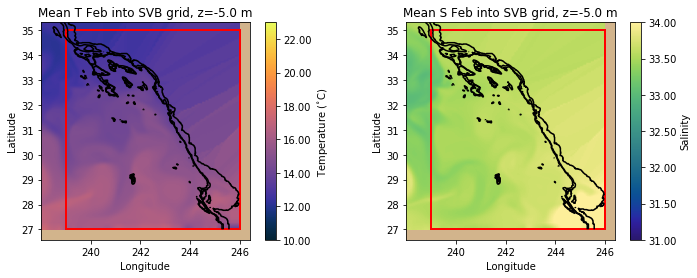

In [64]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4)) 
zz = 0
ax0 = plot_fld_anim(ax0,XC_svb[0,:],YC_svb[:,0],T_feb_reshape[zz,:,:],'Mean T Feb into SVB grid, z=%1.1f m' %(ZC[zz]),
                    vmin=10,vmax=23,cmap=cmo.cm.thermal,clab='Temperature ($^{\circ}$C)')
cn0 = ax0.contour(XC_svb,YC_svb,depth_SVB, levels=[0,250, 500], colors='k')

ax1 = plot_fld_anim(ax1,XC_svb[0,:],YC_svb[:,0],S_feb_reshape[zz,:,:],'Mean S Feb into SVB grid, z=%1.1f m' %(ZC[zz]),
                    vmin=31,vmax=34,cmap=cmo.cm.haline,clab='Salinity')
cn1 = ax1.contour(XC_svb,YC_svb,depth_SVB, levels=[0,250, 500], colors='k')

plt.show()

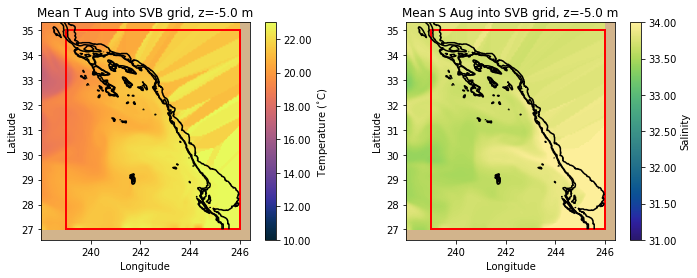

In [65]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4)) 
zz = 0
ax0 = plot_fld_anim(ax0,XC_svb[0,:],YC_svb[:,0],T_aug_reshape[zz,:,:],'Mean T Aug into SVB grid, z=%1.1f m' %(ZC[zz]),
                    vmin=10,vmax=23,cmap=cmo.cm.thermal,clab='Temperature ($^{\circ}$C)')
cn0 = ax0.contour(XC_svb,YC_svb,depth_SVB, levels=[0,250, 500], colors='k')

ax1 = plot_fld_anim(ax1,XC_svb[0,:],YC_svb[:,0],S_aug_reshape[zz,:,:],'Mean S Aug into SVB grid, z=%1.1f m' %(ZC[zz]),
                    vmin=31,vmax=34,cmap=cmo.cm.haline,clab='Salinity')
cn1 = ax1.contour(XC_svb,YC_svb,depth_SVB, levels=[0,250, 500], colors='k')
plt.show()

Deeper layers:

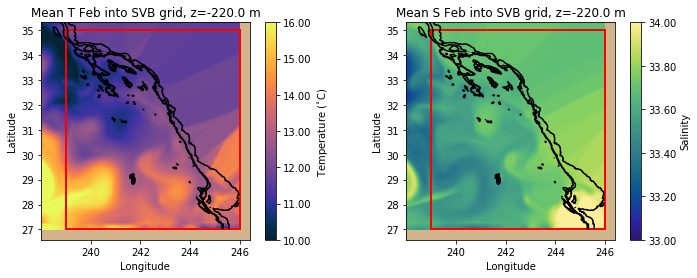

In [66]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4)) 
zz = 20
ax0 = plot_fld_anim(ax0,XC_svb[0,:],YC_svb[:,0],T_feb_reshape[zz,:,:],
                    'Mean T Feb into SVB grid, z=%1.1f m' %(ZC[zz]),
                    vmin=10,vmax=16,cmap=cmo.cm.thermal,clab='Temperature ($^{\circ}$C)')
cn0 = ax0.contour(XC_svb,YC_svb,depth_SVB, levels=[0,250, 500], colors='k')

ax1 = plot_fld_anim(ax1,XC_svb[0,:],YC_svb[:,0],S_feb_reshape[zz,:,:],
                    'Mean S Feb into SVB grid, z=%1.1f m' %(ZC[zz]),
                    vmin=34,vmax=33,cmap=cmo.cm.haline,clab='Salinity')
cn1 = ax1.contour(XC_svb,YC_svb,depth_SVB, levels=[0,250, 500], colors='k')
plt.show()

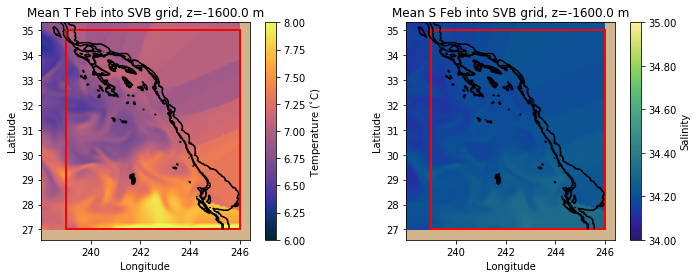

In [67]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4)) 
zz = 50
ax0 = plot_fld_anim(ax0,XC_svb[0,:],YC_svb[:,0],T_feb_reshape[zz,:,:],
                    'Mean T Feb into SVB grid, z=%1.1f m' %(ZC[zz]),
                    vmin=6,vmax=8,cmap=cmo.cm.thermal,clab='Temperature ($^{\circ}$C)')
cn0 = ax0.contour(XC_svb,YC_svb,depth_SVB, levels=[0,250, 500], colors='k')

ax1 = plot_fld_anim(ax1,XC_svb[0,:],YC_svb[:,0],S_feb_reshape[zz,:,:],
                    'Mean S Feb into SVB grid, z=%1.1f m' %(ZC[zz]),
                    vmin=34,vmax=35,cmap=cmo.cm.haline,clab='Salinity')
cn1 = ax1.contour(XC_svb,YC_svb,depth_SVB, levels=[0,250, 500], colors='k')
plt.show()

I don't worry too much about the small artifacts near the cosat that may intrude into the ocean cells because I will let the model spin up for some days to smooth horizontal gradients a bit.

### 3. Save binary files

16.58,16.57,16.56,16.55,16.54,16.54,16.53,16.52,16.51,16.50,16.49,16.47,16.45,16.42,16.38,16.33,16.23,16.13,15.99,15.86,15.69,15.52,15.31,15.08,14.80,14.52,14.20,13.86,13.47,13.04,12.58,12.13,11.68,11.27,10.91,10.57,10.25,9.94,9.64,9.43,9.23,9.03,8.82,8.63,8.44,8.26,8.06,7.84,7.62,7.38,7.14,6.91,6.72,6.54,6.36,6.19,6.04,5.91,5.78,5.65,5.53,5.40,5.27,5.13,5.00,4.85,4.70,4.56,4.41,4.27,4.13,3.99,3.84,3.68,3.51,3.33,3.16,2.98,2.80,2.65,2.49,2.34,2.20,2.09,2.03,1.99,1.94,1.89,1.85,1.80,1.75,1.70,1.65,1.61,1.56,1.51,1.46,1.40,1.41,1.42,

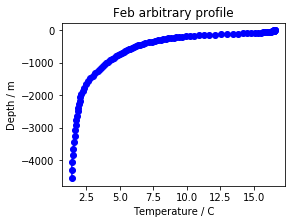

In [68]:
dt = np.dtype('>f8')  # float 64 big endian

# Save binary file
filename = "%dx%dx%d/feb_temp_%dzlev_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx,nyy)
fileobj = open(filename,mode='wb')
T_feb_reshape.astype(dt).tofile(fileobj,"")
fileobj.close()

# Plot a profile
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(T_feb_reshape[:,20,45]),ZC_svb,'bo-')
    
plt.xlabel('Temperature / C')
plt.ylabel('Depth / m')
    
plt.title('Feb arbitrary profile')
for tt in T_feb_reshape[:,20,45]:
    print('%1.2f' %tt, end=",")

33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.63,33.64,33.64,33.64,33.65,33.65,33.66,33.66,33.67,33.69,33.70,33.72,33.75,33.77,33.78,33.80,33.82,33.84,33.86,33.88,33.91,33.94,33.96,33.99,34.01,34.04,34.07,34.09,34.12,34.15,34.16,34.17,34.18,34.19,34.20,34.23,34.25,34.27,34.29,34.31,34.32,34.34,34.35,34.36,34.37,34.38,34.39,34.40,34.41,34.42,34.44,34.45,34.47,34.48,34.49,34.51,34.52,34.54,34.55,34.56,34.57,34.58,34.59,34.60,34.61,34.62,34.63,34.64,34.65,34.66,34.67,34.68,34.68,34.68,34.68,34.68,34.68,34.68,34.69,34.69,34.69,34.69,34.71,

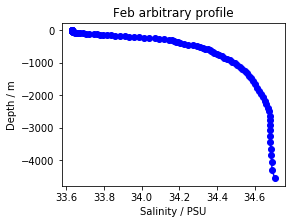

In [69]:
dt = np.dtype('>f8')  # float 64 big endian

# Save binary file
filename = "%dx%dx%d/feb_sal_%dzlev_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx,nyy)
fileobj = open(filename,mode='wb')
S_feb_reshape.astype(dt).tofile(fileobj,"")
fileobj.close()

# Plot a profile
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(S_feb_reshape[:,20,45]),ZC_svb,'bo-')
    
plt.xlabel('Salinity / PSU')
plt.ylabel('Depth / m')
    
plt.title('Feb arbitrary profile')
for tt in S_feb_reshape[:,20,45]:
    print('%1.2f' %tt, end=",")

20.69,20.67,20.65,20.64,20.62,20.60,20.57,20.54,20.47,20.39,20.32,19.99,19.60,19.15,18.52,17.85,17.24,16.63,16.13,15.64,15.23,14.83,14.49,14.14,13.85,13.56,13.28,12.99,12.68,12.34,11.99,11.64,11.29,10.97,10.69,10.45,10.22,9.98,9.75,9.56,9.38,9.22,9.04,8.86,8.68,8.48,8.28,8.08,7.88,7.67,7.45,7.23,7.03,6.84,6.65,6.47,6.30,6.15,6.00,5.86,5.72,5.57,5.42,5.27,5.14,5.00,4.85,4.70,4.55,4.40,4.25,4.09,3.93,3.76,3.59,3.41,3.24,3.07,2.89,2.75,2.60,2.45,2.30,2.16,2.07,2.01,1.95,1.89,1.83,1.77,1.71,1.64,1.59,1.55,1.52,1.48,1.44,1.39,1.41,1.42,

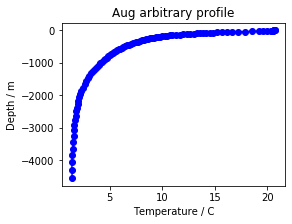

In [70]:
dt = np.dtype('>f8')  # float 64 big endian

# Save binary file
filename = "%dx%dx%d/aug_temp_%dzlev_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx,nyy)
fileobj = open(filename,mode='wb')
T_aug_reshape.astype(dt).tofile(fileobj,"")
fileobj.close()

# Plot a profile
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(T_aug_reshape[:,20,45]),ZC_svb,'bo-')
    
plt.xlabel('Temperature / C')
plt.ylabel('Depth / m')
    
plt.title('Aug arbitrary profile')
for tt in T_aug_reshape[:,20,45]:
    print('%1.2f' %tt, end=",")

33.56,33.56,33.56,33.56,33.56,33.56,33.56,33.55,33.55,33.54,33.54,33.52,33.49,33.47,33.45,33.43,33.42,33.41,33.40,33.40,33.40,33.40,33.41,33.41,33.42,33.43,33.45,33.46,33.48,33.50,33.52,33.55,33.59,33.63,33.68,33.74,33.80,33.86,33.92,33.96,34.00,34.03,34.06,34.09,34.11,34.13,34.15,34.16,34.18,34.20,34.22,34.24,34.25,34.27,34.29,34.31,34.33,34.34,34.36,34.37,34.38,34.39,34.40,34.40,34.41,34.43,34.44,34.45,34.46,34.47,34.48,34.49,34.50,34.51,34.52,34.53,34.54,34.55,34.57,34.58,34.59,34.60,34.61,34.62,34.63,34.64,34.65,34.66,34.67,34.68,34.68,34.68,34.68,34.69,34.69,34.70,34.70,34.71,34.70,34.71,

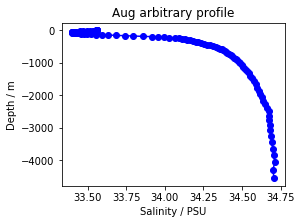

In [71]:
dt = np.dtype('>f8')  # float 64 big endian

# Save binary file
filename = "%dx%dx%d/aug_sal_%dzlev_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx,nyy)
fileobj = open(filename,mode='wb')
S_aug_reshape.astype(dt).tofile(fileobj,"")
fileobj.close()

# Plot a profile
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(S_aug_reshape[:,20,45]),ZC_svb,'bo-')
    
plt.xlabel('Salinity / PSU')
plt.ylabel('Depth / m')
    
plt.title('Aug arbitrary profile')
for tt in S_aug_reshape[:,20,45]:
    print('%1.2f' %tt, end=",")

### Tref and Sref density profiles

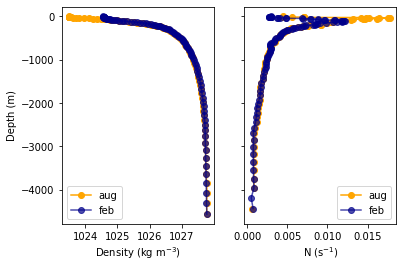

In [72]:
pden_feb = sw.pden(np.squeeze(S_feb_reshape[:,20,45]),
                   np.squeeze(T_feb_reshape[:,20,45]),ZC_svb)
pden_aug = sw.pden(np.squeeze(S_aug_reshape[:,20,45]),
                   np.squeeze(T_aug_reshape[:,20,45]),ZC_svb)

N2_feb,q,pave_feb  = sw.bfrq(np.squeeze(S_feb_reshape[:,20,45]),
                   np.squeeze(T_feb_reshape[:,20,45]),-np.array(ZC_svb))
N2_aug,q,pave_aug  = sw.bfrq(np.squeeze(S_aug_reshape[:,20,45]),
                   np.squeeze(T_aug_reshape[:,20,45]),-np.array(ZC_svb))


fig,(ax,ax2) = plt.subplots(1,2,figsize=(6,4), sharey=True)
ax.plot(pden_aug,ZC_svb,'-o', color='orange', label='aug')
ax.plot(pden_feb,ZC_svb,'-o', color='darkblue', label='feb' ,alpha=0.7)
ax.set_xlabel(r'Density (kg m$^{-3}$)')
ax.set_ylabel('Depth (m)')
ax.legend()

ax2.plot(np.sqrt(N2_aug),-pave_aug,'-o', color='orange', label='aug')
ax2.plot(np.sqrt(N2_feb),-pave_feb,'-o', color='darkblue', label='feb' ,alpha=0.7)
ax2.set_xlabel(r'N (s$^{-1}$)')
ax2.legend()


In [73]:
# Save open boundary binary files feb (constant in time)
dt = np.dtype('>f8')  # float 64 big endian

# Northern boundary
Ns_feb = np.squeeze(S_feb_reshape[:,-1,:])
filename = "%dx%dx%d/Ns_feb_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx)
fileobj = open(filename,mode='wb')
Ns_feb.astype(dt).tofile(fileobj,"")
fileobj.close()

Nt_feb = np.squeeze(T_feb_reshape[:,-1,:])
filename = "%dx%dx%d/Nt_feb_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx)
fileobj = open(filename,mode='wb')
Nt_feb.astype(dt).tofile(fileobj,"")
fileobj.close()

# Southern boundary
Ss_feb = np.squeeze(S_feb_reshape[:,0,:])
filename = "%dx%dx%d/Ss_feb_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx)
fileobj = open(filename,mode='wb')
Ss_feb.astype(dt).tofile(fileobj,"")
fileobj.close()

St_feb = np.squeeze(T_feb_reshape[:,0,:])
filename = "%dx%dx%d/St_feb_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx)
fileobj = open(filename,mode='wb')
St_feb.astype(dt).tofile(fileobj,"")
fileobj.close()

# Western boundary
Ws_feb = np.squeeze(S_feb_reshape[:,:,0])
filename = "%dx%dx%d/Ws_feb_%dx%d.bin" %(nxx,nyy,nzz,nzz,nyy)
fileobj = open(filename,mode='wb')
Ws_feb.astype(dt).tofile(fileobj,"")
fileobj.close()

Wt_feb = np.squeeze(T_feb_reshape[:,:,0])
filename = "%dx%dx%d/Wt_feb_%dx%d.bin" %(nxx,nyy,nzz,nzz,nyy)
fileobj = open(filename,mode='wb')
Wt_feb.astype(dt).tofile(fileobj,"")
fileobj.close()



In [74]:
# Save open boundary binary files aug (constant in time)

# Northern boundary
Ns_aug = np.squeeze(S_aug_reshape[:,-1,:])
filename = "%dx%dx%d/Ns_aug_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx)
fileobj = open(filename,mode='wb')
Ns_aug.astype(dt).tofile(fileobj,"")
fileobj.close()

Nt_aug = np.squeeze(T_aug_reshape[:,-1,:])
filename = "%dx%dx%d/Nt_aug_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx)
fileobj = open(filename,mode='wb')
Nt_aug.astype(dt).tofile(fileobj,"")
fileobj.close()

# Southern boundary
Ss_aug = np.squeeze(S_aug_reshape[:,0,:])
filename = "%dx%dx%d/Ss_aug_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx)
fileobj = open(filename,mode='wb')
Ss_aug.astype(dt).tofile(fileobj,"")
fileobj.close()

St_aug = np.squeeze(T_aug_reshape[:,0,:])
filename = "%dx%dx%d/St_aug_%dx%d.bin" %(nxx,nyy,nzz,nzz,nxx)
fileobj = open(filename,mode='wb')
St_aug.astype(dt).tofile(fileobj,"")
fileobj.close()

# Western boundary
Ws_aug = np.squeeze(S_aug_reshape[:,:,0])
filename = "%dx%dx%d/Ws_aug_%dx%d.bin" %(nxx,nyy,nzz,nzz,nyy)
fileobj = open(filename,mode='wb')
Ws_aug.astype(dt).tofile(fileobj,"")
fileobj.close()

Wt_aug = np.squeeze(T_aug_reshape[:,:,0])
filename = "%dx%dx%d/Wt_aug_%dx%d.bin" %(nxx,nyy,nzz,nzz,nyy)
fileobj = open(filename,mode='wb')
Wt_aug.astype(dt).tofile(fileobj,"")
fileobj.close()



In [75]:
# Save open boundary binary files FEBRUARY (constant in time, but with explicit time records 
# to use when extrenal forcing cycle is on)

ntt = 120
dt = np.dtype('>f8')  # float 64 big endian

# Northern boundary
Ns_feb_cp = np.squeeze(S_feb_reshape[:,-1,:])
Ns_feb_exf = np.expand_dims(Ns_feb_cp,0)
Ns_feb_exf = Ns_feb_exf + np.zeros((ntt,nzz,nxx))
filename = "%dx%dx%d/Ns_feb_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nxx)
fileobj = open(filename,mode='wb')
Ns_feb_exf.astype(dt).tofile(fileobj,"")
fileobj.close()

Nt_feb_cp = np.squeeze(T_feb_reshape[:,-1,:])
Nt_feb_exf = np.expand_dims(Nt_feb_cp,0)
Nt_feb_exf = Nt_feb_exf + np.zeros((ntt,nzz,nxx))
filename = "%dx%dx%d/Nt_feb_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nxx)
fileobj = open(filename,mode='wb')
Nt_feb_exf.astype(dt).tofile(fileobj,"")
fileobj.close()

# Southern boundary
Ss_feb_cp = np.squeeze(S_feb_reshape[:,0,:])
Ss_feb_exf = np.expand_dims(Ss_feb_cp,0)
Ss_feb_exf = Ss_feb_exf + np.zeros((ntt,nzz,nxx))
filename = "%dx%dx%d/Ss_feb_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nxx)
fileobj = open(filename,mode='wb')
Ss_feb_exf.astype(dt).tofile(fileobj,"")
fileobj.close()

St_feb_cp = np.squeeze(T_feb_reshape[:,0,:])
St_feb_exf = np.expand_dims(St_feb_cp,0)
St_feb_exf = St_feb_exf + np.zeros((ntt,nzz,nxx))
filename = "%dx%dx%d/St_feb_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nxx)
fileobj = open(filename,mode='wb')
St_feb_exf.astype(dt).tofile(fileobj,"")
fileobj.close()

# Western boundary
Ws_feb_cp = np.squeeze(S_feb_reshape[:,:,0])
Ws_feb_exf = np.expand_dims(Ws_feb_cp,0)
Ws_feb_exf = Ws_feb_exf + np.zeros((ntt,nzz,nyy))
filename = "%dx%dx%d/Ws_feb_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nyy)
fileobj = open(filename,mode='wb')
Ws_feb_exf.astype(dt).tofile(fileobj,"")
fileobj.close()

Wt_feb_cp = np.squeeze(T_feb_reshape[:,:,0])
Wt_feb_exf = np.expand_dims(Wt_feb_cp,0)
Wt_feb_exf = Wt_feb_exf + np.zeros((ntt,nzz,nyy))
filename = "%dx%dx%d/Wt_feb_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nyy)
fileobj = open(filename,mode='wb')
Wt_feb_exf.astype(dt).tofile(fileobj,"")
fileobj.close()


In [76]:
# Save open boundary binary files AUGUST (constant in time, but with explicit time records 
# to use when extrenal forcing cycle is on)

ntt = 120
dt = np.dtype('>f8')  # float 64 big endian

# Northern boundary
Ns_aug_cp = np.squeeze(S_aug_reshape[:,-1,:])
Ns_aug_exf = np.expand_dims(Ns_aug_cp,0)
Ns_aug_exf = Ns_aug_exf + np.zeros((ntt,nzz,nxx))
filename = "%dx%dx%d/Ns_aug_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nxx)
fileobj = open(filename,mode='wb')
Ns_aug_exf.astype(dt).tofile(fileobj,"")
fileobj.close()

Nt_aug_cp = np.squeeze(T_aug_reshape[:,-1,:])
Nt_aug_exf = np.expand_dims(Nt_aug_cp,0)
Nt_aug_exf = Nt_aug_exf + np.zeros((ntt,nzz,nxx))
filename = "%dx%dx%d/Nt_aug_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nxx)
fileobj = open(filename,mode='wb')
Nt_aug_exf.astype(dt).tofile(fileobj,"")
fileobj.close()

# Southern boundary
Ss_aug_cp = np.squeeze(S_aug_reshape[:,0,:])
Ss_aug_exf = np.expand_dims(Ss_aug_cp,0)
Ss_aug_exf = Ss_aug_exf + np.zeros((ntt,nzz,nxx))
filename = "%dx%dx%d/Ss_aug_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nxx)
fileobj = open(filename,mode='wb')
Ss_aug_exf.astype(dt).tofile(fileobj,"")
fileobj.close()

St_aug_cp = np.squeeze(T_aug_reshape[:,0,:])
St_aug_exf = np.expand_dims(St_aug_cp,0)
St_aug_exf = St_aug_exf + np.zeros((ntt,nzz,nxx))
filename = "%dx%dx%d/St_aug_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nxx)
fileobj = open(filename,mode='wb')
St_aug_exf.astype(dt).tofile(fileobj,"")
fileobj.close()

# Western boundary
Ws_aug_cp = np.squeeze(S_aug_reshape[:,:,0])
Ws_aug_exf = np.expand_dims(Ws_aug_cp,0)
Ws_aug_exf = Ws_aug_exf + np.zeros((ntt,nzz,nyy))
filename = "%dx%dx%d/Ws_aug_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nyy)
fileobj = open(filename,mode='wb')
Ws_aug_exf.astype(dt).tofile(fileobj,"")
fileobj.close()

Wt_aug_cp = np.squeeze(T_aug_reshape[:,:,0])
Wt_aug_exf = np.expand_dims(Wt_aug_cp,0)
Wt_aug_exf = Wt_aug_exf + np.zeros((ntt,nzz,nyy))
filename = "%dx%dx%d/Wt_aug_%dx%dx%d.bin" %(nxx,nyy,nzz,ntt,nzz,nyy)
fileobj = open(filename,mode='wb')
Wt_aug_exf.astype(dt).tofile(fileobj,"")
fileobj.close()